In [1]:
!pip install scikit-learn pandas matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
# Load and Prepare Dataset
url = "/content/breast-cancer.csv"
df = pd.read_csv(url)
print(df.columns)
columns_to_drop = [col for col in ['id', 'Unnamed: 32'] if col in df.columns]
df.drop(columns=columns_to_drop, inplace=True)

# Convert 'diagnosis' to binary values: M=1, B=0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (optional, for boundary plots we reduce to 2D later)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [12]:
#VM with Linear and RBF Kernel
# Linear Kernel SVM
svc_linear=SVC(kernel='linear')
svc_linear.fit(X_train, y_train)
y_pred_linear=svc_linear.predict(X_test)

# RBF Kernel SVM
svc_rbf=SVC(kernel='rbf')
svc_rbf.fit(X_train, y_train)
y_pred_rbf=svc_rbf.predict(X_test)

print("Linear Kernel Classification Report:\n", classification_report(y_test, y_pred_linear))
print("RBF Kernel Classification Report:\n", classification_report(y_test, y_pred_rbf))


Linear Kernel Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

RBF Kernel Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



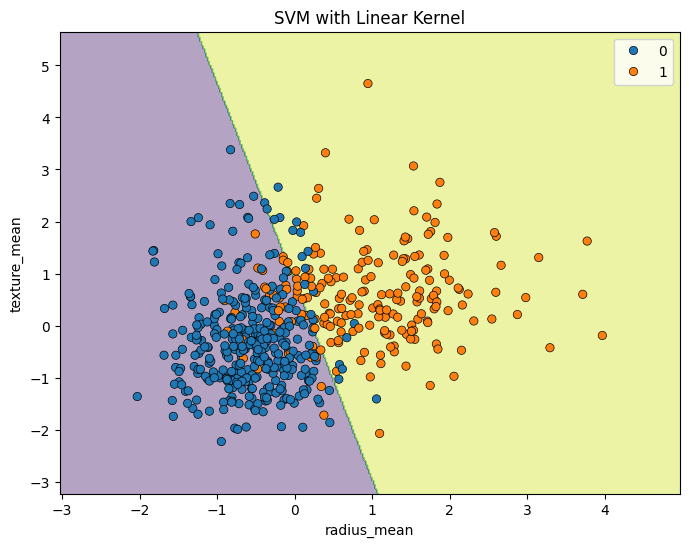

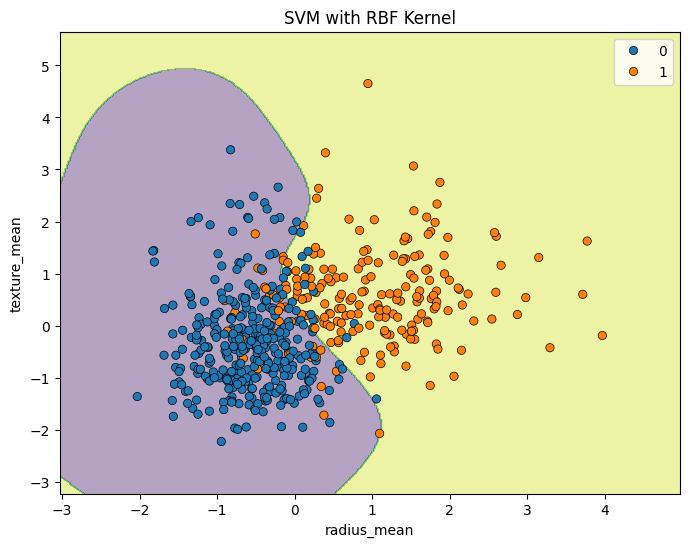

In [11]:
#Visualize Decision Boundary (Using Only 2 Features)
# Select 2D subset for visualization
X_vis=X[['radius_mean', 'texture_mean']].values
y_vis=y.values

X_vis_scaled=StandardScaler().fit_transform(X_vis)

# Fit and visualize
def plot_decision_boundary(clf, X, y, title):
    h = .02
    x_min, x_max=X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max=X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy=np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z=Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, edgecolor='k')
    plt.title(title)
    plt.xlabel('radius_mean')
    plt.ylabel('texture_mean')
    plt.show()

# Linear boundary
svc_linear_2d=SVC(kernel='linear')
svc_linear_2d.fit(X_vis_scaled, y_vis)
plot_decision_boundary(svc_linear_2d, X_vis_scaled, y_vis, "SVM with Linear Kernel")

# RBF boundary
svc_rbf_2d=SVC(kernel='rbf')
svc_rbf_2d.fit(X_vis_scaled, y_vis)
plot_decision_boundary(svc_rbf_2d, X_vis_scaled, y_vis, "SVM with RBF Kernel")


In [9]:
#Hyperparameter Tuning (C and gamma)
param_grid={
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}
grid=GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_scaled, y)
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best score: 0.9789318428815401


In [10]:
#Cross-Validation Performance
best_model=grid.best_estimator_
cv_scores=cross_val_score(best_model, X_scaled, y, cv=5)
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-validation accuracy scores: [0.97368421 0.97368421 0.98245614 0.97368421 0.99115044]
Mean CV Accuracy: 0.9789318428815401
